In [2]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

In [3]:
s_path=Path.cwd()
#s_prt_path=s_path.parent

sRutaPrint=s_path.joinpath('Print')
sRutaPrint

WindowsPath('c:/Alejo/Eje de Planeación/Análisis Eléctrico/ScriptsPython/Print')

In [3]:
objetoAPI = pydataxm.ReadDB()                    #Se almacena el servicio en el nombre objetoAPI

In [4]:
df =objetoAPI.get_collections()   

### Descargar las colecciones disponibles en la API

In [5]:
df.to_csv('Collections.csv')
df.head(5)

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...


#### Descarga de generación real

In [50]:
df_dataGen=pd.DataFrame()

for year in range(2013,2025,1):

    print(year)
    if year<2024:
        monthIni=1
        dayIni=1
        monthFin=12
        dayFin=31
    else:
        monthIni=1
        dayIni=1
        monthFin=8
        dayFin=18        

    FechaIni=dt.date(year, monthIni, dayIni)
    FechaFin=dt.date(year, monthFin, dayFin)

    df_GenReal= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                            "Gene",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                            "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                            FechaIni,       #Corresponde a la fecha inicial de la consulta
                            FechaFin)      #Corresponde a la fecha final de la consulta
    
   
    
    df_GenReal.fillna(0, inplace=True)

    df_Rec= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ListadoRecursos",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
    
    df_Rec.drop(['Date','Id'],axis=1,inplace=True)

    df_Gen_Type=df_GenReal.merge(df_Rec,left_on=['Values_code'],right_on=['Values_Code'], how='left')

    df_Gen_Type=df_Gen_Type[df_Gen_Type.Values_Disp=='NO DESPACHADO CENTRALMENTE']

    columns_name=list(df_Gen_Type.columns)[2:26]
    icont=1
    df_Gen_Type['Gendia']=0
    for iname in columns_name:
        df_Gen_Type['Gendia']=df_Gen_Type['Gendia']+df_Gen_Type[iname]/1000
        df_Gen_Type.rename(columns={iname:icont},inplace=True)
        icont+=1
    
    df_Gen_Type=df_Gen_Type[['Values_Name','Values_Type','Values_Disp','Date','Gendia']]
    df_DayType=df_Gen_Type.groupby(['Date','Values_Type','Values_Disp'])[['Gendia']].sum()
    df_DayType.reset_index(inplace=True)

    df_dataGen=pd.concat([df_dataGen,df_DayType])

2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [52]:
with pd.ExcelWriter(str(sRutaPrint) + '\GenRealDia.xlsx',engine='xlsxwriter') as writer:
    df_dataGen.to_excel(writer, sheet_name='GendiaMenor', index=False)

In [18]:
df_dataAp=pd.DataFrame()

for year in range(2013,2025,1):

    print(year)
    if year<2024:
        monthIni=1
        dayIni=1
        monthFin=12
        dayFin=31
    else:
        monthIni=1
        dayIni=1
        monthFin=8
        dayFin=18    

    FechaIni=dt.date(year, monthIni, dayIni)
    FechaFin=dt.date(year, monthFin, dayFin)
             
    df_Aportes= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                            "AporEner",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                            "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                            FechaIni,       #Corresponde a la fecha inicial de la consulta
                            FechaFin)      #Corresponde a la fecha final de la consulta
    df_Aportes.rename(columns={'Value':'Aportes'},inplace=True)

    df_dataAp=pd.concat([df_dataAp,df_Aportes])

df_dataAp=df_dataAp[['Date','Aportes']]

df_dataAp['Aportes']=df_dataAp['Aportes']/1000

2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [19]:
with pd.ExcelWriter(str(sRutaPrint) + '\AportesDia.xlsx',engine='xlsxwriter') as writer:
    df_dataAp.to_excel(writer, sheet_name='AportesDia', index=False)

### Cargar datos y ejecutar modelo

In [4]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

In [6]:
s_path=Path.cwd()
#s_prt_path=s_path.parent

sRutaPrint=s_path.joinpath('Print')
sRutaPrint

WindowsPath('c:/Alejo/Eje de Planeación/Análisis Eléctrico/ScriptsPython/Print')

In [21]:
df_data=pd.read_excel(str(sRutaPrint) + '\GenRealDia.xlsx', sheet_name='GendiaMenor')
df_dataAp=pd.read_excel(str(sRutaPrint) + '\AportesDia.xlsx', sheet_name='AportesDia')

### Cargar datos y ejecutar modelo

In [1]:
from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

In [2]:
s_path=Path.cwd()
#s_prt_path=s_path.parent
sRutaPrint=s_path.joinpath('Print')
sRutaPrint

df_data=pd.read_excel(str(sRutaPrint) + '\GenRealDia.xlsx', sheet_name='GendiaMenor')
df_dataAp=pd.read_excel(str(sRutaPrint) + '\AportesDia.xlsx', sheet_name='AportesDia')

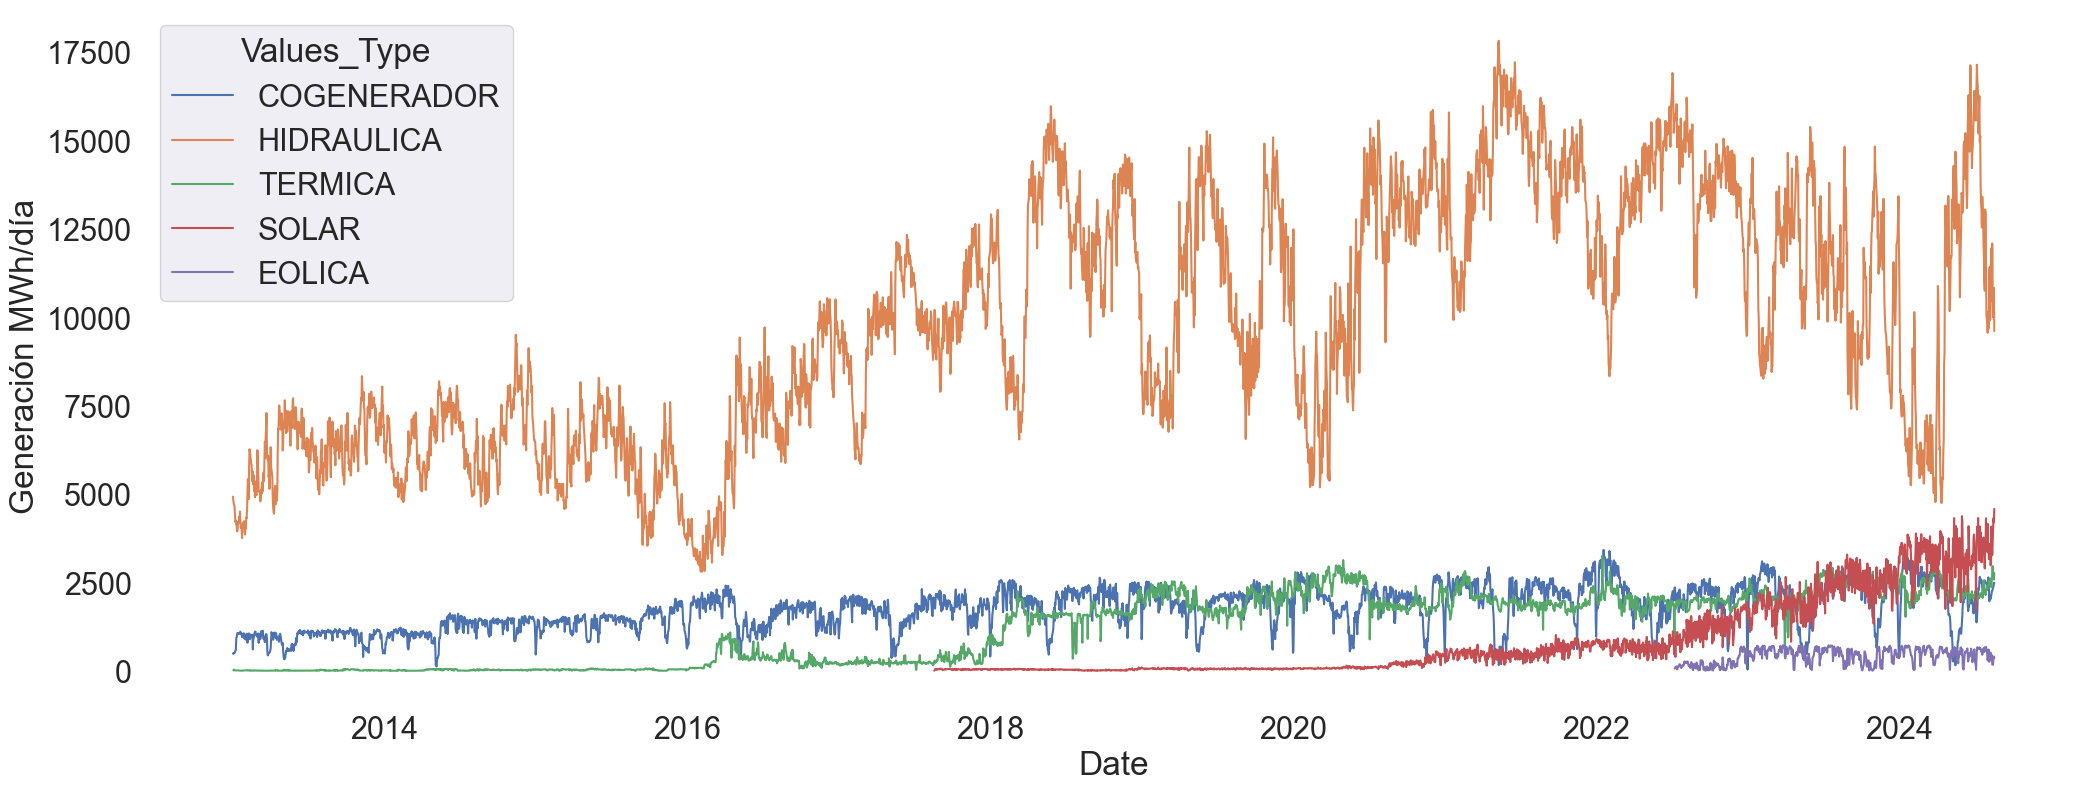

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Graficar de nuevo los datos
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(25,9)})
sns.set(style="whitegrid")
sns.set(font_scale=2)
sns.lineplot(data = df_data, x='Date', y='Gendia',hue='Values_Type')
ax.set_ylabel('Generación MWh/día')
ax.set_facecolor('white')
sns.despine(left=True)

In [5]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,tipo):

     if tipo=='Weekday':
          return row['Date'].weekday()
     elif tipo=='TypeDay':
          if row['Date'] in co_holidays:
               return 3
          elif row['Date'].weekday()==5:
               return 2
          elif row['Date'].weekday()==6:
               return 3
          else:
               return 1
     elif tipo=='Month':
          return row['Date'].month
     elif tipo=='Year':
          return row['Date'].year

# Realizar pronóstico

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from evaluation._mae import MAE
from evaluation._smape import sMAPE
from evaluation._mape import MAPE
from evaluation._rmse import RMSE

In [7]:
# Dividir los datos en train, validación y test
def split_data(data, indexTotal, train_fraq, test_len=8760):

    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(data)-test_len

    test_data = data[test_slice:]
    indexTest=indexTotal[test_slice:]

    train_val_data = data[:test_slice]
    index_val_data=indexTotal[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    indexTrain=index_val_data[:train_size]

    val_data = train_val_data[train_size:]
    indexVal=index_val_data[train_size:]
    
    return train_data, val_data, test_data, indexTrain, indexVal, indexTest

In [8]:
# Crear los datos para entrar al modelo, definición de ventanas
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    #ds = ds.shuffle(shuffle_buffer)
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

# Construcción del dataset usando las ventanas
def build_dataset(traindata,valdata,testdata,train_fraq=0.65, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    
    train_ds = window_dataset(traindata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(valdata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(testdata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

In [134]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        # tf.keras.layers.LSTM(30, activation='relu', return_sequences=False),
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dropout(0.3),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    # loss = tf.keras.losses.Huber()
    loss='mse'
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae','mape'])
    
    return model

In [10]:
df_data=df_data.merge(df_dataAp,left_on=['Date'],right_on=['Date'], how='left')

In [135]:
df_GenHid=df_data.copy()
# df_GenHid=df_GenHid[df_GenHid.Values_Type=='HIDRAULICA'][['Date','Gendia','Aportes']]
df_GenHid=df_GenHid[df_GenHid.Values_Type=='HIDRAULICA'][['Date','Gendia']]

# Agregar tipo de día
df_GenHid['TypeDay']=df_GenHid.apply(lambda row: typedays(row,tipo='TypeDay'),axis=1)
# Definir día de la semana
df_GenHid['Weekday']=df_GenHid.apply(lambda row: typedays(row,tipo='Weekday'),axis=1)
# Definir mes
df_GenHid['Month']=df_GenHid.apply(lambda row: typedays(row,tipo='Month'),axis=1)
# Definir año
df_GenHid['Year']=df_GenHid.apply(lambda row: typedays(row,tipo='Year'),axis=1)

# Remover la fecha al dataset
col=df_GenHid.columns[1:]
dataset=df_GenHid[col]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4248 entries, 1 to 16036
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Gendia   4248 non-null   float64
 1   TypeDay  4248 non-null   int64  
 2   Weekday  4248 non-null   int64  
 3   Month    4248 non-null   int64  
 4   Year     4248 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 199.1 KB


In [136]:
df_GenHid.head(5)

,Date,Gendia,TypeDay,Weekday,Month,Year
1,2013-01-01,4925.62655,3,1,1,2013
3,2013-01-02,4799.93577,1,2,1,2013
6,2013-01-03,4731.06990,1,3,1,2013
9,2013-01-04,4684.38623,1,4,1,2013
12,2013-01-05,4620.25446,2,5,1,2013


### Ver correlaciones

In [13]:
df=df_GenHid[df_GenHid.columns[1:]]

In [14]:
MinMax = MinMaxScaler(copy=True, feature_range=(0, 1)) 
nombres = df.columns
Datos_Min_Max = MinMax.fit_transform(df)
Datos_Min_Max = pd.DataFrame(Datos_Min_Max, columns = nombres)

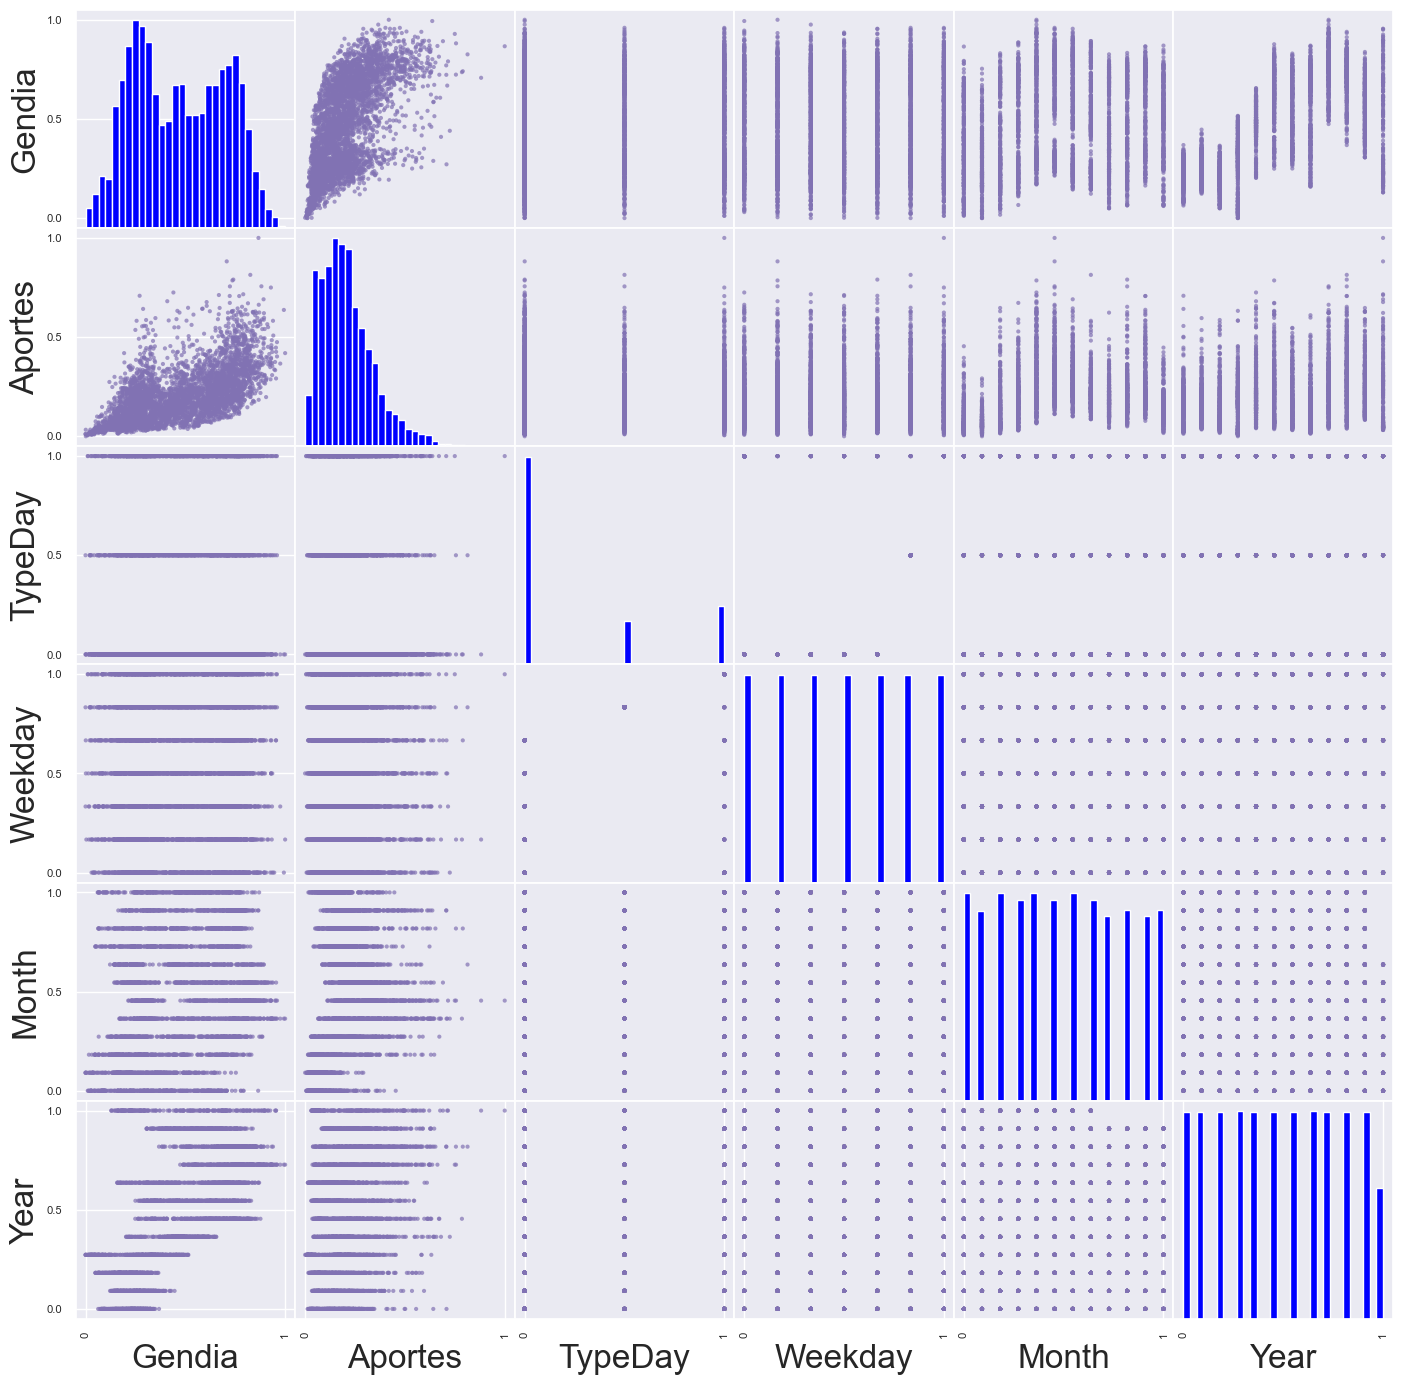

In [15]:
#Se realiza una gráfica para observar la correlación de los datos
pd.plotting.scatter_matrix(Datos_Min_Max, alpha=0.7, figsize=(17,17), range_padding = 0.1, diagonal='hist',
                           color = 'm', hist_kwds = {'bins':30, 'color':'blue'}) # Grafica de dispersión e histograma
plt.show()

,Gendia,Aportes,TypeDay,Weekday,Month,Year
Gendia,1.000000,0.609375,0.030124,0.011820,0.220191,0.659677
Aportes,0.609375,1.000000,0.018565,0.007012,0.228179,0.252290
TypeDay,0.030124,0.018565,1.000000,0.610232,0.003939,0.001318
Weekday,0.011820,0.007012,0.610232,1.000000,0.001263,0.000911
Month,0.220191,0.228179,0.003939,0.001263,1.000000,-0.058964


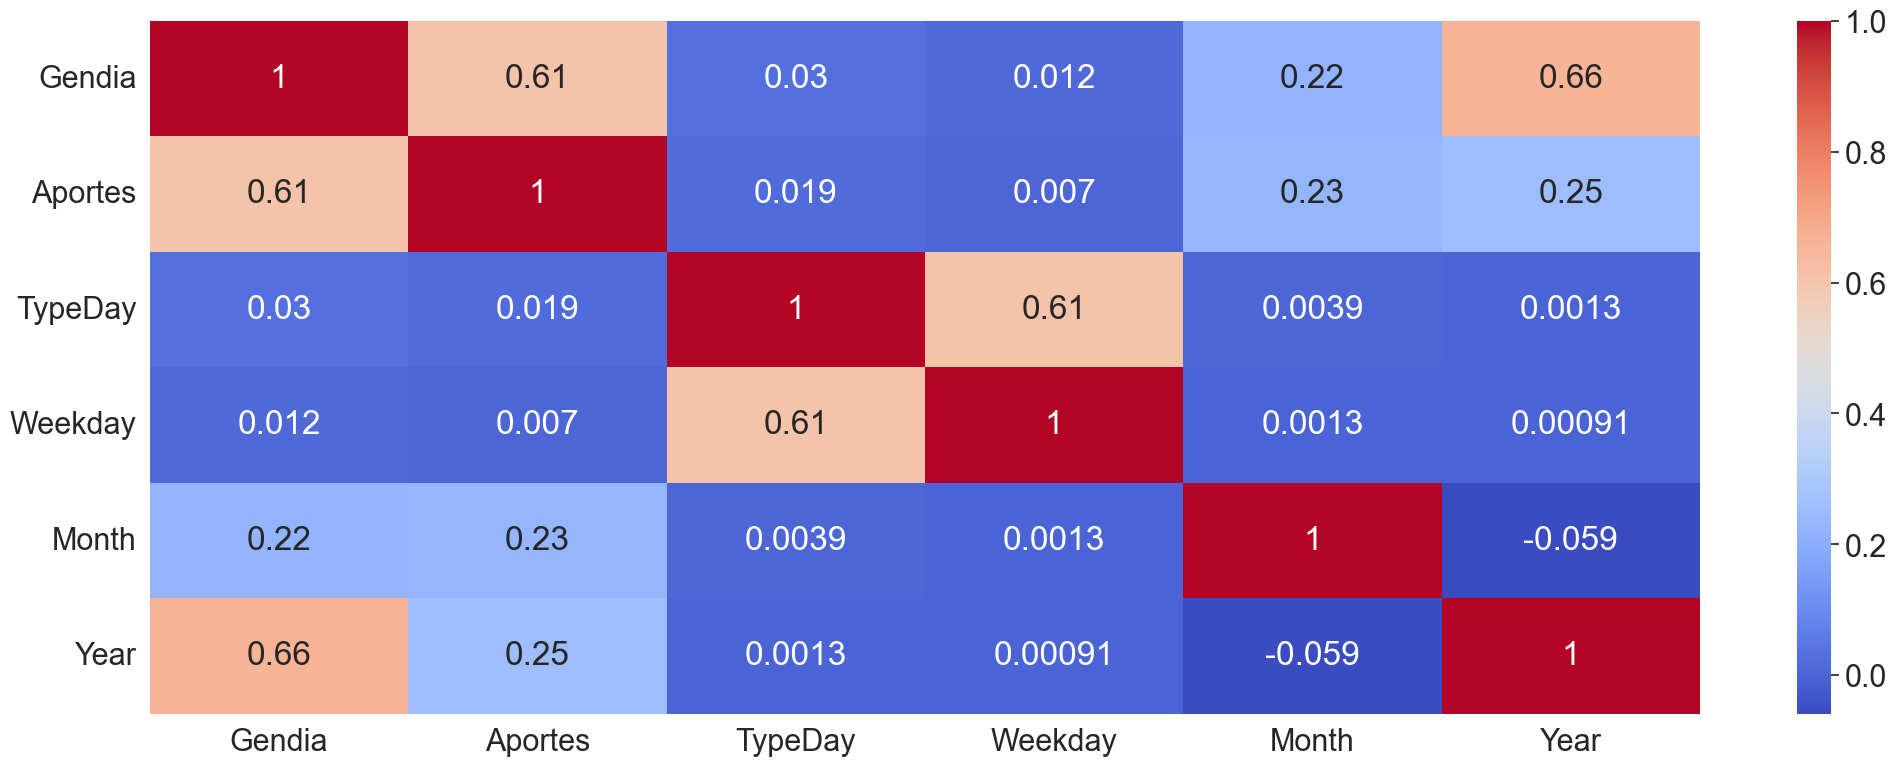

In [16]:
matriz_corr=Datos_Min_Max.corr()
sns.heatmap(Datos_Min_Max.corr(), annot=True, cmap='coolwarm')
matriz_corr.head()

### Determinación del modelo

In [137]:
# Normalizar los datos
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))

#Normalizar la entrada
X = scalerX.fit_transform(dataset)

#Normalizar la salida, el reshape es para convertir el venctor en otro de dos dimensiones
Y = scalerY.fit_transform(dataset.values[:,0].reshape(-1,1))

In [138]:
indexTotal=dataset.index
train_multi, val_multi, test_multi, indexTrain, indexVal, indexTest = split_data(X,indexTotal, train_fraq=0.65, test_len=90)

print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")
print('Generación',Y.shape)
print('Todo',dataset.shape)

Multivarate Datasets
Train Data Shape: (2702, 5)
Val Data Shape: (1456, 5)
Test Data Shape: (90, 5)
Nulls In Train False
Nulls In Validation False
Nulls In Test False
Generación (4248, 1)
Todo (4248, 5)


In [139]:
n_steps=24
n_horizon=1
nepochs=100
n_features=5
lr= 3e-4

train_ds, val_ds, test_ds = build_dataset(train_multi, val_multi, test_multi,n_steps=n_steps, n_horizon=n_horizon,batch_size=300,multi_var=True)
print('Example sample shapes')
for idx,(x,y) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Prediction lookback (n_steps): 24
Prediction horizon (n_horizon): 1
Batch Size: 300
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Example sample shapes
x =  (300, 24, 5)
y =  (300, 1, 1)


In [140]:
for idx,(x,y) in enumerate(train_ds):
    print("Xtr = ", x.numpy().shape)
    print("Ytr = ", y.numpy().shape)
    Xtr= x.numpy()
    Ytr=y.numpy()
    break

for idx,(x,y) in enumerate(val_ds):
    print("Xval = ", x.numpy().shape)
    print("Yval = ", y.numpy().shape)
    Xval= x.numpy()
    Yval=y.numpy()
    break

for idx,(x,y) in enumerate(test_ds):
    print("Xts = ", x.numpy().shape)
    print("Yts = ", y.numpy().shape)
    Xts= x.numpy()
    Yts=y.numpy()
    break

Xtr =  (300, 24, 5)
Ytr =  (300, 1, 1)
Xval =  (300, 24, 5)
Yval =  (300, 1, 1)
Xts =  (66, 24, 5)
Yts =  (66, 1, 1)


In [141]:
model = lstm_model(n_steps, n_horizon, n_features, lr=lr)
model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            11200     
                                                                 
 dense (Dense)               (None, 24, 1)             51        
                                                                 
Total params: 11251 (43.95 KB)
Trainable params: 11251 (43.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [142]:
model_hist = model.fit(train_ds, validation_data=val_ds, epochs=nepochs)

Epoch 1/100
9/9 [==============================] - 1s 55ms/step - loss: 0.2157 - mae: 0.4258 - mape: 6485.9087 - val_loss: 0.4599 - val_mae: 0.6561 - val_mape: 101.5841
Epoch 2/100
9/9 [==============================] - 0s 33ms/step - loss: 0.0825 - mae: 0.2365 - mape: 43860.9648 - val_loss: 0.1761 - val_mae: 0.3725 - val_mape: 55.7019
Epoch 3/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0436 - mae: 0.1618 - mape: 100203.2500 - val_loss: 0.0992 - val_mae: 0.2451 - val_mape: 42.2283
Epoch 4/100
9/9 [==============================] - 0s 34ms/step - loss: 0.0481 - mae: 0.1772 - mape: 110056.3672 - val_loss: 0.0969 - val_mae: 0.2496 - val_mape: 40.5258
Epoch 5/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0398 - mae: 0.1556 - mape: 96311.0312 - val_loss: 0.0957 - val_mae: 0.2527 - val_mape: 40.3555
Epoch 6/100
9/9 [==============================] - 0s 30ms/step - loss: 0.0348 - mae: 0.1424 - mape: 93484.7812 - val_loss: 0.0821 - val_mae: 0.2254 - va

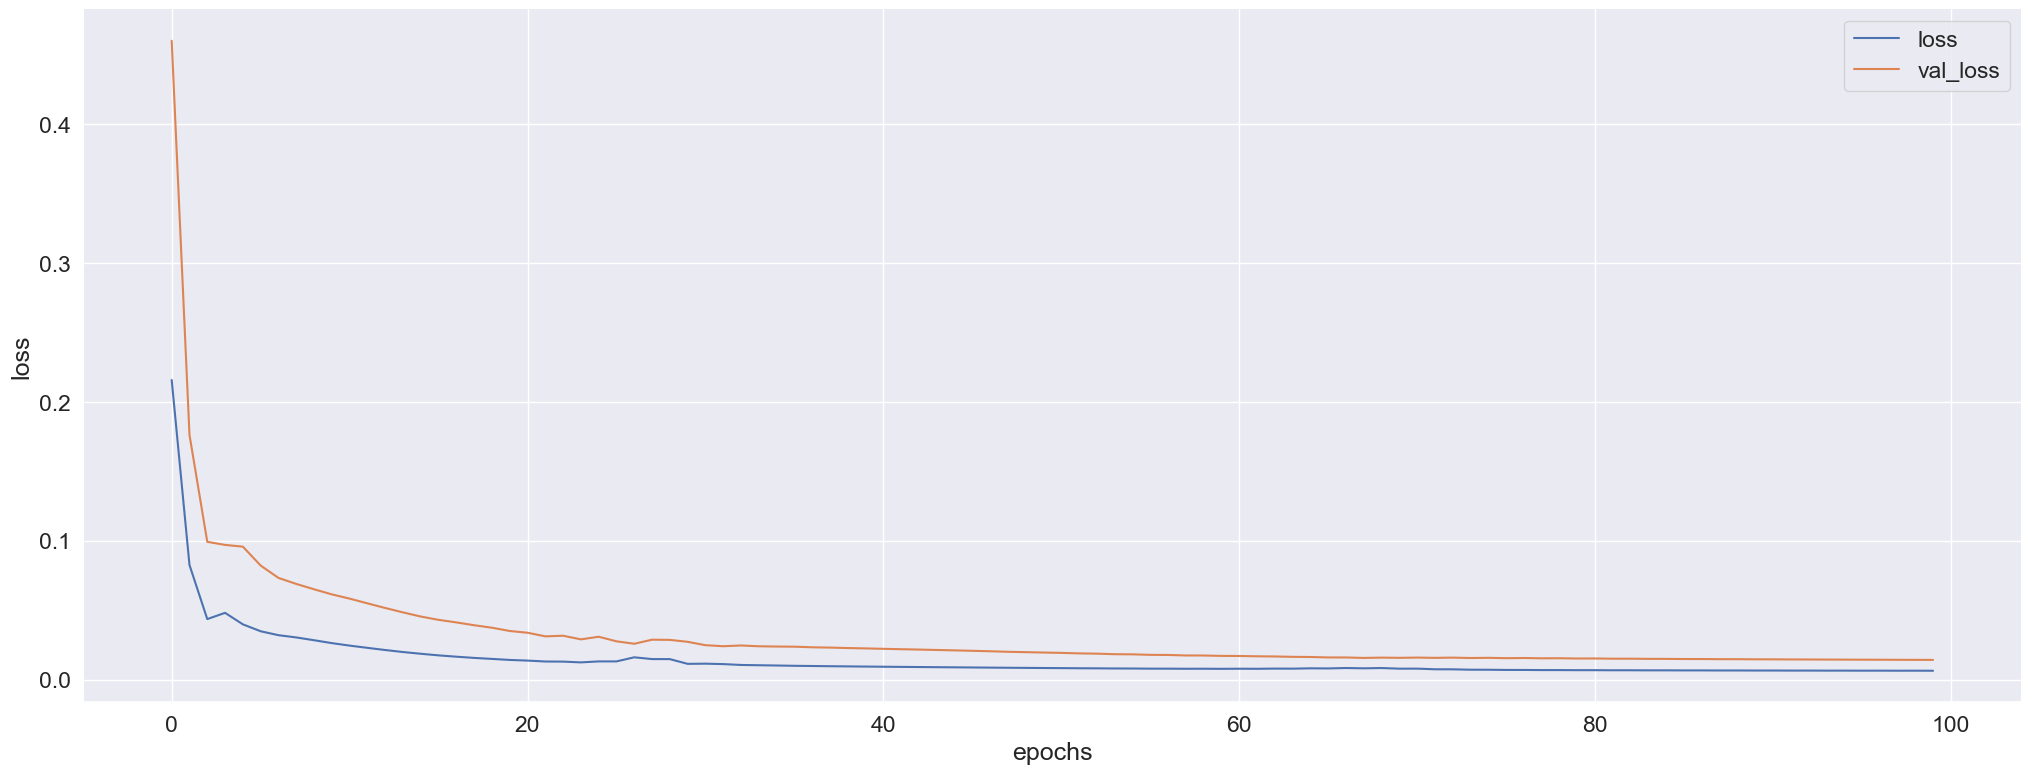

In [143]:
fig, axs = plt.subplots()

metric='loss'

# sns.lineplot(val['history'].history[metric],ax=axs[i1,i])
# sns.lineplot(val['history'].history[f'val_{metric}'],ax=axs[i1,i])
sns.set_theme(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
axs.plot(model_hist.history[metric])
axs.plot(model_hist.history[f'val_{metric}'])
axs.legend([metric, f"val_{metric}"])
axs.set_xlabel('epochs')
axs.set_ylabel(metric)
ax.set_ylabel('Generación MWh/día')
ax.set_facecolor('white')
sns.despine(left=True)



In [147]:
Ytr.shape

(300, 1, 1)

In [149]:
results=pd.DataFrame(columns=['Model','Tipo','MAE','MAPE','sMAPE','RMSE'])

#Evaluación de los X de entrenamiento
Yp=model.predict(Xtr)
Ye=scalerY.inverse_transform(Ytr.reshape(Ytr.shape[0],n_horizon))
Yp=scalerY.inverse_transform(Yp)
mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

data=pd.DataFrame([{'Model':'LSTM','Tipo':'Train','MAE':mae_validation,'MAPE':mape_validation,
    'sMAPE':smape_validation,'RMSE':rmse_validation}])
results=pd.concat([results,data])

#Evaluación de las X en validación
Yp=model.predict(Xval)
Ye=scalerY.inverse_transform(Yval.reshape(Yval.shape[0],n_horizon))
Yp=scalerY.inverse_transform(Yp)
mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

data=pd.DataFrame([{'Model':'LSTM','Tipo':'Val','MAE':mae_validation,'MAPE':mape_validation,
    'sMAPE':smape_validation,'RMSE':rmse_validation}])
results=pd.concat([results,data])

# Hacer pedicciones con el Xtest
# Xts=tipomodelo['Xts']
# Yts=tipomodelo['Yts'].reshape(Yts.shape[0],24)
Yp=model.predict(Xts)
Ye=scalerY.inverse_transform(Yts.reshape(Yts.shape[0],n_horizon))
Yp=scalerY.inverse_transform(Yp)

mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
data=pd.DataFrame([{'Model':'LSTM','Tipo':'Test','MAE':mae_validation,'MAPE':mape_validation,
    'sMAPE':smape_validation,'RMSE':rmse_validation}])
results=pd.concat([results,data])

10/10 [==============================] - 0s 2ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
results

,Model,Tipo,MAE,MAPE,sMAPE,RMSE
0,LSTM,Train,551.523359,9.587059,9.090260,675.185550
0,LSTM,Val,747.596324,5.690782,5.709969,967.803174
0,LSTM,Test,1022.131562,8.015669,7.761331,1237.728472


3/3 [==============================] - 0s 8ms/step


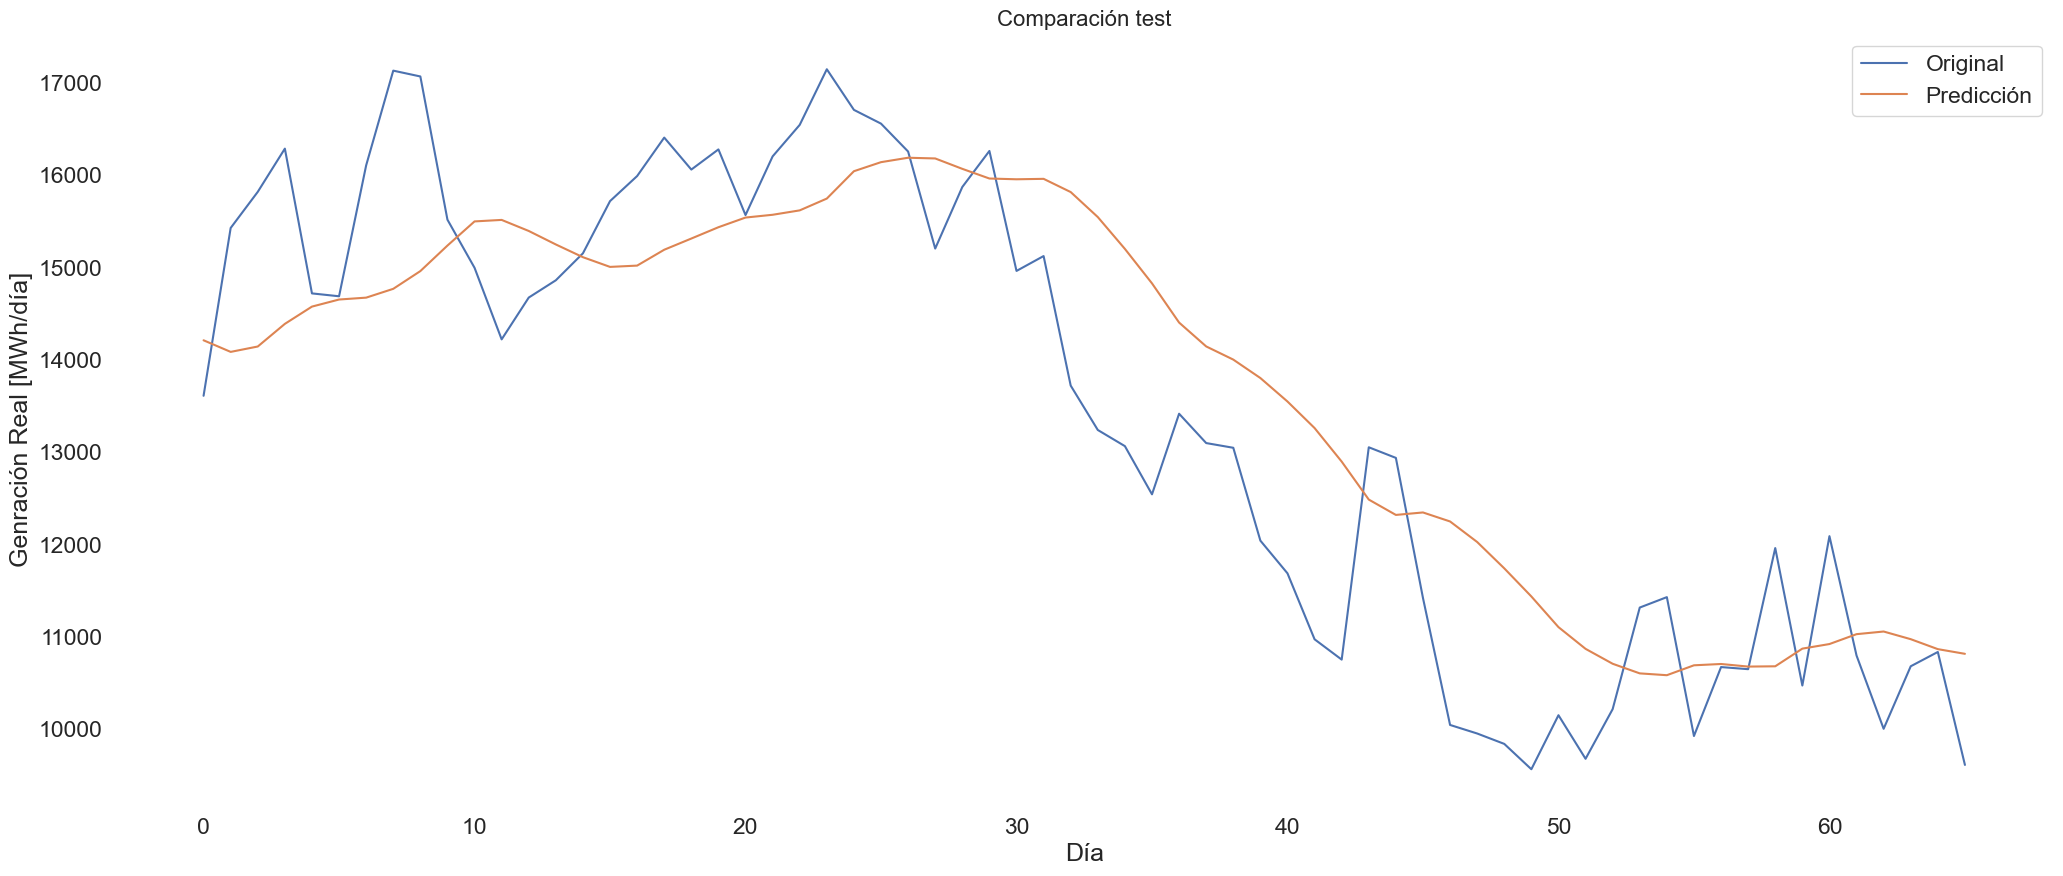

In [ ]:
fig, axs = plt.subplots(figsize=(25,10))  # create a new figure with a default 111 subplot

Ypred = model.predict(Xts)

Ye=Yts.reshape(-1,1)
Ye=scalerY.inverse_transform(Ye)

Yp=Ypred.reshape(-1,1)
Yp=scalerY.inverse_transform(Yp)

sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
axs.plot(Ye, label='Original')
axs.plot(Yp, label='Predicción')
axs.set_title('Comparación test')
axs.set_xlabel("Día")
axs.set_ylabel("Genración Real [MWh/día]")
axs.legend(['Original','Predicción'],facecolor='white')
axs.set_facecolor('white')